# Face Classification with Modified PCA and K-Means Clustering


## Eric Sun and Eric Wasserman
## AM 205 Final Project

In [1]:
# Import necessary packages
import numpy as np
import math
import matplotlib.pyplot as plt
import os

### Auto-cropping of faces using face recognition algorithm

In [2]:
import cv2 as cv #Opencv
from PIL import Image #Image from PIL
import glob
import os

def DetectFace(image, faceCascade, returnImage=False):
    # This function takes a grey scale cv image and finds
    # the patterns defined in the haarcascade function
    # modified from: http://www.lucaamore.com/?p=638

    #variables    
    min_size = (20,20)
    haar_scale = 1.1
    min_neighbors = 3
    haar_flags = 0

    # Equalize the histogram
    cv.EqualizeHist(image, image)

    # Detect the faces
    faces = cv.HaarDetectObjects(
            image, faceCascade, cv.CreateMemStorage(0),
            haar_scale, min_neighbors, haar_flags, min_size
        )

    # If faces are found
    if faces and returnImage:
        for ((x, y, w, h), n) in faces:
            # Convert bounding box to two CvPoints
            pt1 = (int(x), int(y))
            pt2 = (int(x + w), int(y + h))
            cv.Rectangle(image, pt1, pt2, cv.RGB(255, 0, 0), 5, 8, 0)

    if returnImage:
        return image
    else:
        return faces

def pil2cvGrey(pil_im):
    # Convert a PIL image to a greyscale cv image
    # from: http://pythonpath.wordpress.com/2012/05/08/pil-to-opencv-image/
    pil_im = pil_im.convert('L')
    cv_im = cv.CreateImageHeader(pil_im.size, cv.IPL_DEPTH_8U, 1)
    cv.SetData(cv_im, pil_im.tostring(), pil_im.size[0]  )
    return (cv_im)

def cv2pil(cv_im):
    # Convert the cv image to a PIL image
    return Image.fromstring("L", cv.GetSize(cv_im), cv_im.tostring())

def imgCrop(image, cropBox, boxScale=1):
    # Crop a PIL image with the provided box [x(left), y(upper), w(width), h(height)]

    # Calculate scale factors
    xDelta=max(cropBox[2]*(boxScale-1),0)
    yDelta=max(cropBox[3]*(boxScale-1),0)

    # Convert cv box to PIL box [left, upper, right, lower]
    PIL_box=[cropBox[0]-xDelta, cropBox[1]-yDelta, cropBox[0]+cropBox[2]+xDelta, cropBox[1]+cropBox[3]+yDelta]

    return image.crop(PIL_box)

def faceCrop(imagePattern,boxScale=1):
    # Select one of the haarcascade files:
    #   haarcascade_frontalface_alt.xml  <-- Best one?
    #   haarcascade_frontalface_alt2.xml
    #   haarcascade_frontalface_alt_tree.xml
    #   haarcascade_frontalface_default.xml
    #   haarcascade_profileface.xml
    faceCascade = cv.Load('haarcascade_frontalface_alt.xml')

    imgList=glob.glob(imagePattern)
    if len(imgList)<=0:
        print ('No Images Found')
        return

    for img in imgList:
        pil_im=Image.open(img)
        cv_im=pil2cvGrey(pil_im)
        faces=DetectFace(cv_im,faceCascade)
        if faces:
            n=1
            for face in faces:
                croppedImage=imgCrop(pil_im, face[0],boxScale=boxScale)
                fname,ext=os.path.splitext(img)
                croppedImage.save(fname+'_crop'+str(n)+ext)
                n+=1
        else:
            print ('No faces found:'), img

# Test the algorithm on an image
#test('testPics/faces.jpg')

# Crop all jpegs in a folder. Note: the code uses glob which follows unix shell rules.
# Use the boxScale to scale the cropping area. 1=opencv box, 2=2x the width and height
#faceCrop('testPics/*.jpg',boxScale=1)

In [ ]:
# Crop all faces to pre-process
faceCrop('./pictures/sun/*.jpg',boxScale=1)

# Face Recognition with Basic Principal Component Analysis

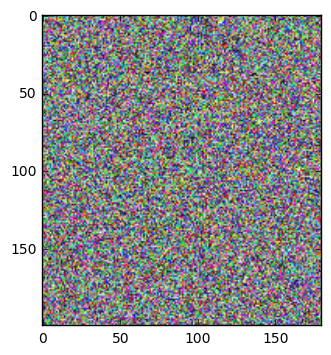

In [4]:
# Part A
import numpy as np
import matplotlib.pyplot as plt
import os

# Reading and converting to subtractive representation
path_dir = './faces94/male/9338446/'
leaf_mats = []

for f in os.listdir(path_dir):
    im = plt.imread(path_dir+f) # read image as 3D numpy array
    S = np.subtract(1,im) # S = 1-p
    # Make a col vector of the image [row by row] [R --> G --> B]
    S_j = S.flatten()
    leaf_mats.append(S_j)
    
#leaf_mats = leaf_mats[:4]
    
# Calculate the average S
L = len(leaf_mats)
S_avg = []
for i in range(len(leaf_mats[0])): # loop through length of vector
    summed_entries = sum([leaf[i] for leaf in leaf_mats]) # sum
    S_avg.append(summed_entries/L) # average
S_avg = np.array(S_avg).T # convert to col vector

# Reshape and plot S_avg as a picture
m = 200
n = 180
d = 3
S_reformatted = S_avg.reshape((m,n,d)) # recast to 3D matrix
S_reformatted_rgb = np.subtract(1,S_reformatted) # recast to RGB
#img = Image.fromarray(S_reformatted_rgb, 'RGB')
#img = Image.fromarray(im, 'RGB')
#img.save('6a.png')
plt.figure()
plt.imshow(S_reformatted_rgb)
#plt.savefig('6a.png')
plt.show()

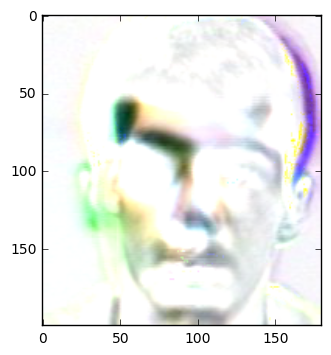

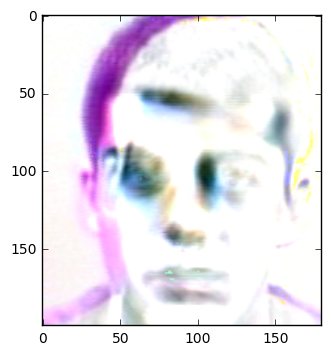

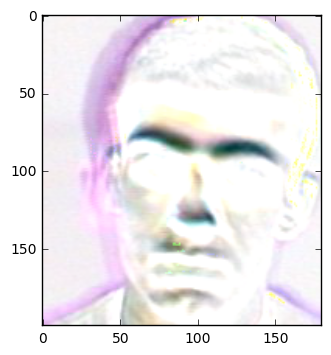

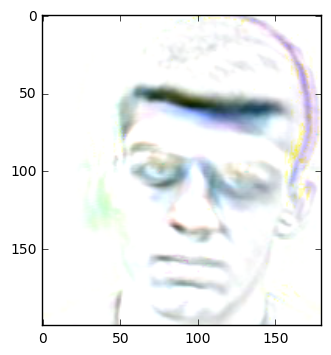

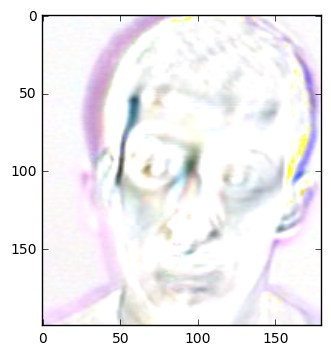

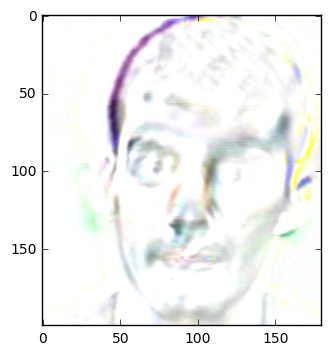

In [5]:
# Part B
import numpy as np

# Get A
mean_subtracted_vectors = [np.subtract(leaf,S_avg) for leaf in leaf_mats] # get mean subtracted leaf vectors
A = np.vstack(mean_subtracted_vectors).T # make matrix of size 3mn x L

# Compute reduced SVD of A
(u, s, v) = np.linalg.svd(A, full_matrices=0)

# Get c and d vectors
c = [] # min of each col of u
d = [] # max of each col of u
for col in range(u.shape[1]):
    c.append(min(u[:,col]))
    d.append(max(u[:,col]))
    
# Get positive and negative components
u_p = np.zeros(u.shape) # init positive component
u_n = np.zeros(u.shape) # init negative component
# iterate entries
for i in range (u.shape[0]):
    for j in range(u.shape[1]):
        u_p[i,j] = max([0, u[i,j]/d[j]]) # from pset
        u_n[i,j] = max([0, u[i,j]/c[j]])

# Plot images of u_p and u_n for j=1,2,3
# loop through, reshape, and re-subtract to get RGB images
m = 200
n = 180
d = 3
for j in [0,1,2]:
    re_mat_p = u_p[:, j].reshape((m,n,d))
    re_mat_n = u_n[:, j].reshape((m,n,d))
    mat_p = np.subtract(1,re_mat_p)
    mat_n = np.subtract(1,re_mat_n)
    plt.figure()
    plt.imshow(mat_p)
    plt.savefig('6b_P'+str(j)+'.png')
    plt.show()
    plt.figure()
    plt.imshow(mat_n)
    #plt.savefig('6b_N'+str(j)+'.png')
    plt.show()

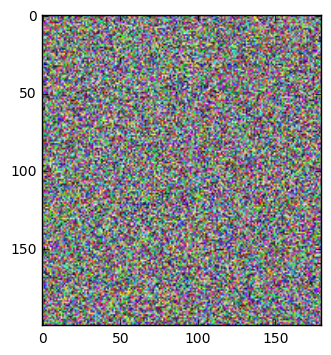

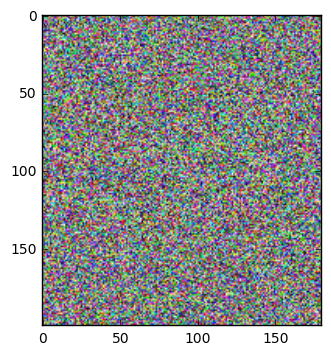

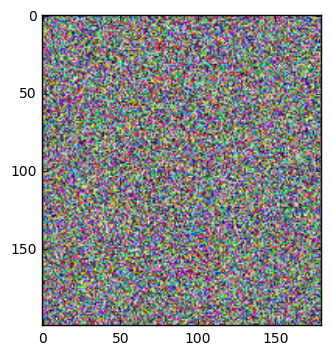

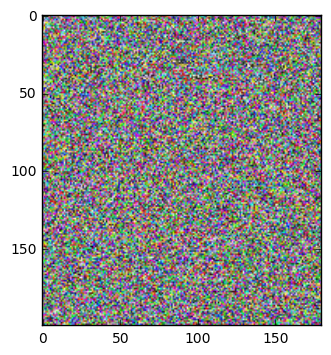

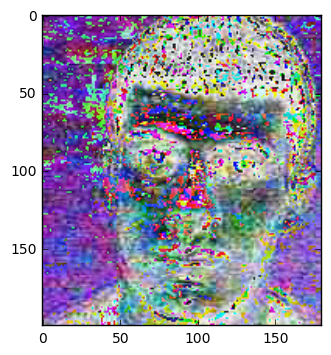

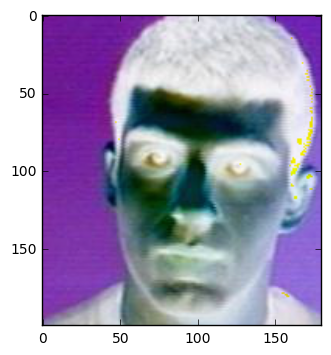

In [8]:
# Part C
from random import randint
import numpy as np

def project (T, U, S_avg, k):
    # taken from pset
    P = 0
    for j in range(k): # sum up to k
        inner_term = np.dot(U[:,j].T, np.subtract(T,S_avg)) # from pset
        outer_term = np.dot(inner_term, U[:,j])
        P += outer_term # add the summation
    P += S_avg
    return (P)

k_list = [1,2,4,8,16,20] # from pset
rand_leaf = randint(0,len(leaf_mats))
S_rand = leaf_mats[rand_leaf] # pick random leaf img

# Visualize projections for different k's
for k in k_list:
    m = 200
    n = 180
    d = 3
    P_k = project(S_rand, u, S_avg, k)
    P_reformatted = P_k.reshape((m,n,d)) # recast to 3D matrix
    P_reformatted_rgb = np.subtract(1,P_reformatted) # recast to RGB
    #P_reformatted_rgb = np.clip(P_reformatted_rgb,0,1)
    plt.figure()
    plt.imshow(P_reformatted_rgb)
    #plt.savefig('6c'+str(k)+'.png')
    plt.show()

19
7


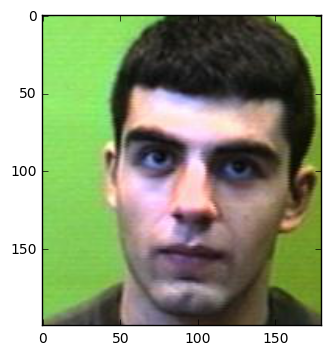

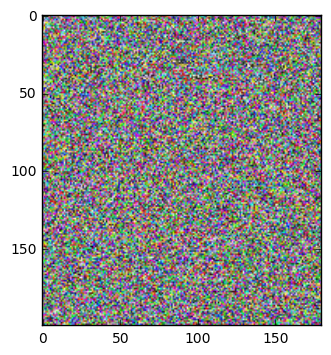

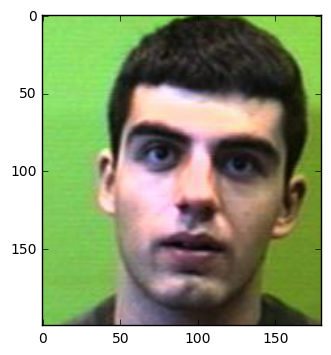

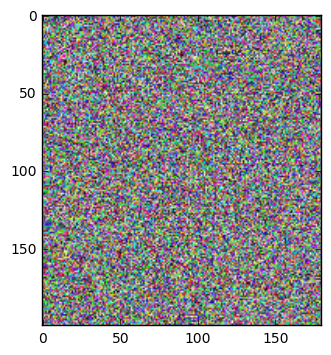

In [9]:
# Part D

# define dis operator per the pset
def dis (Sj, U, S_avg, m=280, n=356, k=8):
    P_Sj = project(Sj, U, S_avg, k) # get projection
    norm_2 = np.linalg.norm(np.subtract(Sj, P_Sj),2) # calc 2-norm of Sj-P(Sj)
    dis_val = 1/(m*n) * (norm_2)**2 # from pset
    return (dis_val)

# loop through and get dis(Sj)
dis_vals = []
for Sj in leaf_mats:
    disj = dis(Sj, u, S_avg)
    dis_vals.append(disj)
    
idx_hi = np.argmax(np.array(dis_vals)) # get hi
print (idx_hi)
idx_lo = np.argmin(np.array(dis_vals)) # get lo
print(idx_lo)

#print(dis_vals[idx_lo])
#print(dis_vals[idx_hi])

# Plot and show
plt.figure()
S_hi = leaf_mats[idx_hi].reshape((m,n,d))
S_hi_ref = np.subtract(1,S_hi)
#S_hi_ref_clp = np.clip(S_hi_ref,0,1)
plt.imshow(S_hi_ref)
#plt.savefig('6d-S_hi.png')
plt.show()

plt.figure()
proj_hi = project(leaf_mats[idx_hi], u, S_avg, 8)
proj_hi = proj_hi.reshape((m,n,d))
proj_hi_ref = np.subtract(1,proj_hi)
#proj_hi_ref_clp = np.clip(proj_hi_ref,0,1)
plt.imshow(proj_hi_ref)
#plt.savefig('6d-P_hi.png')
plt.show()

plt.figure()
S_lo = leaf_mats[idx_lo].reshape((m,n,d))
S_lo_ref = np.subtract(1,S_lo)
#S_lo_ref_clp = np.clip(S_lo_ref,0,1)
plt.imshow(S_lo_ref)
#plt.savefig('6d-S_lo.png')
plt.show()

plt.figure()
proj_lo = project(leaf_mats[idx_lo], u, S_avg, 8)
proj_lo = proj_lo.reshape((m,n,d))
proj_lo_ref = np.subtract(1,proj_lo)
#proj_lo_ref_clp = np.clip(proj_lo_ref,0,1)
plt.imshow(proj_lo_ref)
#plt.savefig('6d-P_lo.png')
plt.show()

In [ ]:
# Part E
import numpy as np
import matplotlib.pyplot as plt
import os

# Reading and converting to subtractive representation
path_dir = 'am205_leaves_356x280/extra/'
leaf_exs = []

for f in os.listdir(path_dir):
    im = plt.imread(path_dir+f) # read image as 3D numpy array
    S = np.subtract(1,im) # S = 1-p
    # Make a col vector of the image [row by row] [R --> G --> B]
    S_j = S.flatten()
    leaf_exs.append(S_j)
    
# Calculate dis(examples) and score
# loop through and get dis(Sj)
dis_vals = []
for Sj in leaf_exs:
    disj = dis(Sj, u, S_avg)
    dis_vals.append(disj)

print ('dis values:')
print(dis_vals)
print(" ")
    
# Get top 3 lowest dis vals
idxs_lo = np.array(dis_vals).argsort()[::-1][-3:]
print ("Lowest three dis vals:")
for idx in idxs_lo:
    print (dis_vals[idx])

for idx in idxs_lo:
    plt.figure()
    S_lo = leaf_exs[idx].reshape((m,n,d))
    S_lo_ref = np.subtract(1,S_lo)
    S_lo_ref_clp = np.clip(S_lo_ref,0,1)
    plt.imshow(S_lo_ref_clp)
    plt.savefig('6e-'+str(idx)+'.png')
    plt.show()